# Analysis of Guam Forest Inventory Survey Data

This iPython notebook creates an SQLite database containing US Forest Service Forest Inventory data collected on Guam in 2002 and 2013.

The Forest Service has kindly provided online access to data from its national forest inventory surveys on its [FIA DataMart](http://apps.fs.fed.us/fiadb-downloads/datamart.html) page. Data are available as Microsoft Access databases (\*.accx) for Windows users and as plain text tables (\*.csv) for Mac and Linux users.

Survey methods and resulting data are very thoroughly documented in PDFs stored in the Access database zip file. For Guam, this is http://apps.fs.fed.us/fiadb-downloads/Databases/GUaccdb.zip. 

### Import libraries used in this script

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

### Connect to SQLite DB

In [2]:
conn = sqlite3.connect('guam_forest_survey.db')

### Find plots that were sampled in 2002 and 2013

According to the data dictionary, a code of 1 in the PLOT_STATUS_CD field indicATES "Sampled - at least one accessible forest land condition present on plot.

In [3]:
sql = 'select PLOT, INVYR from gu_plot where INVYR=2002 and PLOT_STATUS_CD=1'
df_plots_2002 = pd.read_sql(con=conn, sql=sql)
print('{} plots were sampled in 2002.'.format(df_plots_2002.shape[0]))

sql = 'select PLOT, INVYR from gu_plot where INVYR=2013 and PLOT_STATUS_CD=1'
df_plots_2013 = pd.read_sql(con=conn, sql=sql)
print('{} plots were sampled in 2013.'.format(df_plots_2013.shape[0]))

df_plots_2002_2013 = pd.merge(df_plots_2002, df_plots_2013, on='PLOT', how='outer', suffixes=['_2002','_2013'])
df_plots_2002_2013 = df_plots_2002_2013.fillna(0.0).astype(int)

# Resampled is a Series of boolean values indicating which plots were resampled
resampled = (df_plots_2002_2013.INVYR_2002>0) & (df_plots_2002_2013.INVYR_2013>0)
print('{} plots were sampled in both 2002 and 2013.'.format(resampled.sum()))

44 plots were sampled in 2002.
48 plots were sampled in 2013.
42 plots were sampled in both 2002 and 2013.


In [4]:
s = 'PLOT IN ('
for index, row in df_plots_2002_2013[resampled].iterrows():
    s += '"{}",'.format(row.PLOT)
resampled_plots_string = s[:-1] + ')' # Replace last character, which should be a comma, with a closing parenthesis.
resampled_plots_string

'PLOT IN ("66007","66008","66009","66013","66015","66019","66020","66021","66024","66026","66028","66033","66034","66044","66051","66053","66054","66063","66067","66074","66075","66076","66079","66084","66085","66088","66092","66093","66095","66100","66101","66103","66104","66110","66114","66115","66117","66118","66124","66129","66131","66133")'

### Test Queries
Create dataframes containing the number of live trees (DBH >= 5 inches) observed in plots during the 2002 and 2013 surveys. Then merge these into a single dataframe.

### 2002

In [5]:
sql = '''
select gu_tree.SPCD, GENUS, SPECIES, COMMON_NAME, count(*) as TREE_COUNT
from gu_tree, ref_species
where 
'''
sql += resampled_plots_string
sql += '''
    and INVYR = 2002
    and gu_tree.SPCD = ref_species.SPCD
    and DIA >= 5.0
    and STATUSCD = 1
group by gu_tree.SPCD
order by TREE_COUNT desc;
'''
df2002 = pd.read_sql(con=conn, sql=sql)
df2002

,SPCD,GENUS,SPECIES,COMMON_NAME,TREE_COUNT
0,6852,Cycas,circinalis,queen sago,108
1,908,Cocos,nucifera,coconut palm,80
2,7377,Heterospathe,elata,palma brava,73
3,7565,Leucaena,leucocephala,white leadtree,61
4,8874,Vitex,parviflora,smallflower chastetree,61
5,8085,Pandanus,tectorius,Tahitian screwpine,49
6,8307,Premna,obtusifolia,ahgao,48
7,7412,Hibiscus,tiliaceus,sea hibiscus,39
8,6042,Aglaia,mariannensis,Titimel,20
9,885,Mangifera,indica,mango,16


### 2013

In [6]:
sql = '''
select gu_tree.SPCD, GENUS, SPECIES, COMMON_NAME, count(*) as TREE_COUNT
from gu_tree, ref_species
where 
'''
sql += resampled_plots_string
sql += '''
    and INVYR = 2013
    and gu_tree.SPCD = ref_species.SPCD
    and DIA >= 5.0
    and STATUSCD = 1
group by gu_tree.SPCD
order by TREE_COUNT desc;
'''
df2013 = pd.read_sql(con=conn, sql=sql)
df2013

,SPCD,GENUS,SPECIES,COMMON_NAME,TREE_COUNT
0,8874,Vitex,parviflora,smallflower chastetree,134
1,7412,Hibiscus,tiliaceus,sea hibiscus,98
2,908,Cocos,nucifera,coconut palm,92
3,7377,Heterospathe,elata,palma brava,92
4,8085,Pandanus,tectorius,Tahitian screwpine,56
5,7565,Leucaena,leucocephala,white leadtree,54
6,8307,Premna,obtusifolia,ahgao,47
7,6852,Cycas,circinalis,queen sago,26
8,7942,Neisosperma,oppositifolia,fao,24
9,6042,Aglaia,mariannensis,Titimel,18


### Merge 2002 and 2013 Data

In [7]:
df = pd.merge(df2002, df2013, on=['SPCD','GENUS','SPECIES','COMMON_NAME'], how='outer', suffixes=['_2002','_2013'])
# Convert NaNs to 0 and convert from float to integer
df['TREE_COUNT_2002'] = df['TREE_COUNT_2002'].fillna(0.0).astype(int)
df['TREE_COUNT_2013'] = df['TREE_COUNT_2013'].fillna(0.0).astype(int) 
df

,SPCD,GENUS,SPECIES,COMMON_NAME,TREE_COUNT_2002,TREE_COUNT_2013
0,6852.0,Cycas,circinalis,queen sago,108,26
1,908.0,Cocos,nucifera,coconut palm,80,92
2,7377.0,Heterospathe,elata,palma brava,73,92
3,7565.0,Leucaena,leucocephala,white leadtree,61,54
4,8874.0,Vitex,parviflora,smallflower chastetree,61,134
5,8085.0,Pandanus,tectorius,Tahitian screwpine,49,56
6,8307.0,Premna,obtusifolia,ahgao,48,47
7,7412.0,Hibiscus,tiliaceus,sea hibiscus,39,98
8,6042.0,Aglaia,mariannensis,Titimel,20,18
9,885.0,Mangifera,indica,mango,16,17


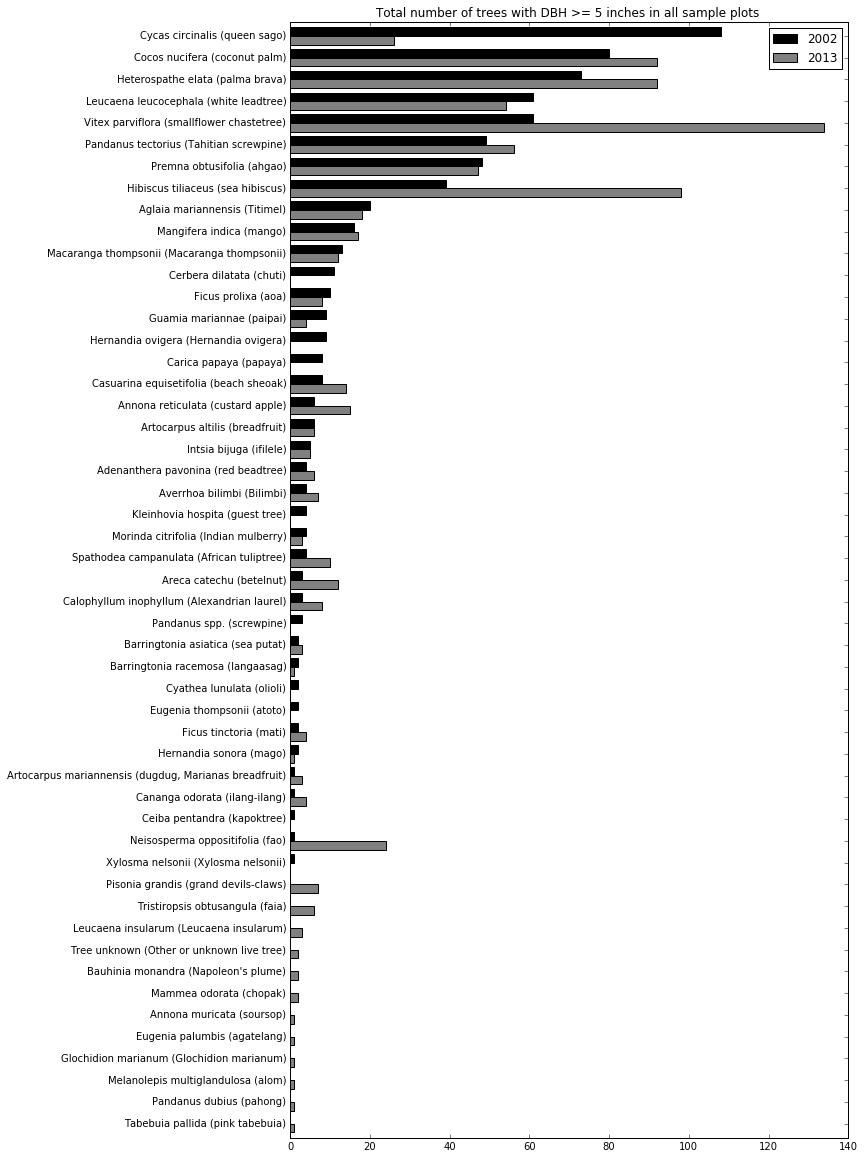

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
df.plot(
    ax=ax,
    title='Total number of trees with DBH >= 5 inches in all sample plots ',
    kind='barh',
    x=df.GENUS+' '+df.SPECIES+' ('+df.COMMON_NAME+')',
    y=['TREE_COUNT_2002','TREE_COUNT_2013'],
    figsize=(10, 20),
    width=0.8,
    color=['black','gray'],
    ylim=(0,150),
    legend=False,
).invert_yaxis()
ax.legend(["2002", "2013"]);